<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C3/C3.html"><img src="../data/C3_nav.png" width="100"  style="float:right;" alt="C3"></a>
<div><h1>DTW Variants</h1> </div>
</div>

<p>
Various modifications have been proposed in order to speed up DTW computations as well as to 
better control the overall course of the warping paths. Following Section 3.2.2 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>, we discuss in this notebook some of these DTW variants. Efficient and robust multiscale versions of DTW are described in the following articles.   
    
<ul>    
<li><span style="color:black">
Thomas Prätzlich, Jonathan Driedger, and Meinard Müller:  <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2016_PraetzlichDriedgerMueller_MrMsDTW_ICASSP.pdf"><strong>Memory-Restricted Multiscale Dynamic Time Warping.</strong></a> Proceedings of the IEEE International Conference on Acoustics, Speech, and Signal Processing (ICASSP): 569&ndash;573, 2016. 
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_PraetzlichDM16_MsDTW_ICASSP.txt"> Bibtex </a>
</span></li>
    
<li><span style="color:black">
Meinard Müller, Henning Mattes, and Frank Kurth: <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2006_MuellerMattesKurth_MultiscaleAudioSynchronization_ISMIR.pdf"><strong>An Efficient Multiscale Approach to Audio Synchronization.</strong></a> Proceedings of the International Conference on Music Information Retrieval (ISMIR): 192–197, 2006.
<br>
<a type="button" class="btn btn-default btn-xs" target="_blank" href="../data/bibtex/FMP_bibtex_MuellerMK06_EfficientMultiscaleApproach_ISMIR.txt"> Bibtex </a>
</span></li>
</ul>   
</p> 

## Step Size Condition

In [classical DTW](../C3/C3S2_DTWbasic.html), the step size condition is expressed by the set $\Sigma=\{(1,0),(0,1),(1,1)\}$. Introducing a kind of local continuity condition, this condition ensures that a warping path aligns each element of the sequence $X=(x_1,x_2,\ldots,x_N)$ to an element of $Y=(y_1,y_2,\ldots,y_M)$ and vice versa. One drawback of this condition is that a single element of one sequence may be assigned to many consecutive elements of the other sequence, which leads to vertical and horizontal sections in the warping path. Intuitively, in such cases the warping path is stuck at some position in one of the sequences, while moving on in the other sequence. In terms of physical time, this situation corresponds to a strong temporal deformation in the alignment of the two time series. To avoid such degenerations, one can modify the step size condition by constraining the slope of the admissible warping paths, which can be done by replacing the set $\Sigma$. This is illustrated by the following figure, which shows three different step size conditions (top) along with some typical warping paths (bottom):

<img src="../data/C3/FMP_C3_F17.png" width="600px" align="center" alt="C1">

In the first case, the original set $\Sigma=\{(1,0),(0,1),(1,1)\}$ is used (observe the degenerations in the warping paths). Replacing this set by 

\begin{equation}
   \Sigma = \{(2,1),(1,2),(1,1)\}
\end{equation}

leads to warping paths having a local slope within the bounds $1/2$ and $2$. For computing an optimal warping path that satisfies the new step size constraints, one only has to slightly modify the [original DTW algorithm](../C3/C3S2_DTWbasic.html). To compute the accumulated cost matrix $\mathbf{D}$, one can use the following recursion:

\begin{equation}
  \mathbf{D}(n,m)= \mathbf{C}(n,m) + \min\left\{
             \begin{array}{l}\mathbf{D}(n-1,m-1),\\ \mathbf{D}(n-2,m-1),\\\mathbf{D}(n-1,m-2) \end{array}\right.
\end{equation}

for $n\in [1:N]$ and $m\in [1:N]$ with $(n,m)\not=(1,1)$. For the initialization, one can use a trick of extending $\mathbf{D}$ by two additional rows and columns (indexed by $-1$ and $0$) and set $\mathbf{D}(1,1):=\mathbf{C}(1,1)$, $\mathbf{D}(n,-1):=\mathbf{D}(n,0):=\infty$ for $n\in [-1:N]$, and $\mathbf{D}(-1,m):=\mathbf{D}(0,m):=\infty$ for $m\in [-1:M]$. Note that, with respect to the modified step size condition, there is a warping path of finite total cost between two sequences $X$ and $Y$. Furthermore, note that not all elements of $X$ need to be assigned to some element of $Y$ and vice versa, which is illustrated by the figure above. The third case of the above figure shows a step size condition which avoids such omissions while imposing constraints on the slope of the warping path. 

## LibFMP Implemetation

In the next code cell, we provide an implementation the DTW algorithm with step size condition $\Sigma=\{(1,1),(2,1),(1,2)\}$. Again note (as already discussed in the [implementation of the classical DTW algorithm](../C3/C3S2_DTWbasic.html)) that there is a systematic index shift of minus one in relation to the algorithmic description given above due to Python indexing conventions.

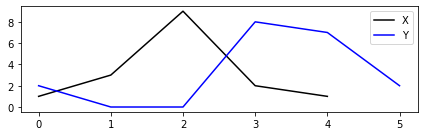

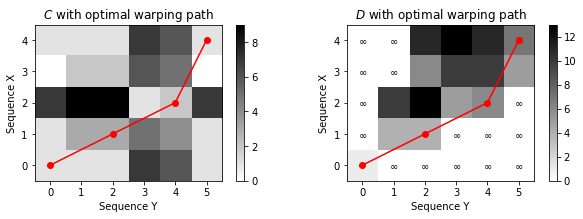

In [1]:
import numpy as np
import scipy.spatial
import librosa
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

import sys
sys.path.append('..')
import LibFMP.C3

@jit(nopython=True)
def compute_accumulated_cost_matrix_21(C):
    """Compute the accumulated cost matrix given the cost matrix

    Notebook: C3/C3S2_DTWbasic.ipynb

    Args:
        C: cost matrix

    Returns:
        D: Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N + 2, M + 2))
    D[:, 0:2] = np.inf
    D[0:2, :] = np.inf
    D[2, 2] = C[0, 0]

    for n in range(N):
        for m in range(M):
            if n == 0 and m == 0:
                continue
            D[n+2, m+2] = C[n, m] + min(D[n-1+2, m-1+2], D[n-2+2, m-1+2], D[n-1+2, m-2+2])
    D = D[2:,2:]
    return D

@jit(nopython=True)
def compute_optimal_warping_path_21(D):
    """Compute the warping path given an accumulated cost matrix

    Notebook: C3/C3S2_DTWbasic.ipynb

    Args:
        D: Accumulated cost matrix

    Returns
        P: Warping path (list of index pairs)
    """
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-2, m-1], D[n-1, m-2])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-2, m-1]:
                cell = (n-2, m-1)
            else:
                cell = (n-1, m-2)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    P = np.array(P)
    return P

# Sequences
X = [1, 3, 9, 2, 1]
Y = [2, 0, 0, 8, 7, 2]
N, M = len(X), len(Y)

C = LibFMP.C3.compute_cost_matrix(X, Y, metric='euclidean')
D = compute_accumulated_cost_matrix_21(C)
P = compute_optimal_warping_path_21(D)  
    
plt.figure(figsize=(6, 2))
plt.plot(X, c='k', label='X')
plt.plot(Y, c='b', label='Y')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(9, 3))
ax = plt.subplot(1, 2, 1)
LibFMP.C3.plot_matrix_with_points(C, P, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, np.max(C)],
    title='$C$ with optimal warping path', xlabel='Sequence Y', ylabel='Sequence X');

ax = plt.subplot(1, 2, 2)
D_max = np.nanmax(D[D != np.inf])
LibFMP.C3.plot_matrix_with_points(D, P, linestyle='-', 
    ax=[ax], aspect='equal', clim=[0, D_max],
    title='$D$ with optimal warping path', xlabel='Sequence Y', ylabel='Sequence X');
for x, y in zip(*np.where(np.isinf(D))):
    plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')

plt.tight_layout()

## LibROSA Implemetation

The DTW function of [LibROSA](https://librosa.github.io/librosa/) allows for specifying arbitrary step size conditions. The following code cell calls the function `librosa.sequence.dtw` with different step size conditions $\Sigma$.

<font color="red"><strong>Note:</strong> For general $\Sigma$, there may not always be a valid warping path fulling both the boundary and the step-size condition. In this case, the function `librosa.sequence.dtw` outputs an **error message** ("No valid sub-sequence warping path could be constructed with the given step sizes").
</font>

Accumulated cost matrix and optimal warping path for different step size conditions:


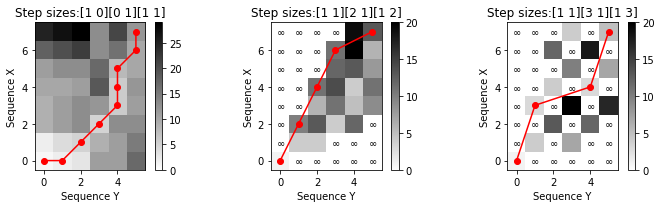

In [2]:
def compute_plot_D_P(X, Y, ax, step_sizes_sigma=np.array([[1, 1], [0, 1], [1, 0]]),
                     weights_mul=np.array([1, 1, 1]), title='',
                     global_constraints=False, band_rad=0.25):
    D, P = librosa.sequence.dtw(X, Y, metric='euclidean', weights_mul=weights_mul,
                    step_sizes_sigma=step_sizes_sigma, 
                    global_constraints=global_constraints, band_rad=band_rad)
    D_max = np.nanmax(D[D != np.inf])
    LibFMP.C3.plot_matrix_with_points(D, P, linestyle='-', 
        ax=[ax], aspect='equal', clim=[0, D_max],
        title= title, xlabel='Sequence Y', ylabel='Sequence X');
    for x, y in zip(*np.where(np.isinf(D))):
        plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')
    
X = [1, 3, 9, 2, 1, 3, 9, 9]
Y = [2, 0, 0, 9, 1, 7]  

print(r'Accumulated cost matrix and optimal warping path for different step size conditions:')
plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 3, 1)
step_sizes_sigma = np.array([[1, 0], [0, 1], [1, 1]])
title='Step sizes:'+''.join(str(s) for s in step_sizes_sigma)
compute_plot_D_P(X, Y, ax=ax, step_sizes_sigma=step_sizes_sigma, title=title)

ax = plt.subplot(1, 3, 2)
step_sizes_sigma = np.array([[1, 1], [2, 1], [1, 2]])
title='Step sizes:'+''.join(str(s) for s in step_sizes_sigma)
compute_plot_D_P(X, Y, ax=ax, step_sizes_sigma=step_sizes_sigma, title=title)

ax = plt.subplot(1, 3, 3)
step_sizes_sigma = np.array([[1, 1], [3, 1], [1, 3]])
title='Step sizes:'+''.join(str(s) for s in step_sizes_sigma)                                                       
compute_plot_D_P(X, Y, ax=ax, step_sizes_sigma=step_sizes_sigma, title=title)

plt.tight_layout()

## Local Weights

To favor the vertical, horizontal, or diagonal direction in the alignment, one can introduce additional **local weights** $w_{\mathrm{d}},w_{\mathrm{h}},w_{\mathrm{v}}\in\mathbb{R}$. To compute the accumulated cost matrix $\mathbf{D}$, one uses the following initialization and recursion:

\begin{eqnarray}
  \mathbf{D}(1,1)&:=&\mathbf{C}(1,1)\\
  \mathbf{D}(n,1)&=&\sum_{k=1}^{n} w_{\mathrm{h}}\cdot \mathbf{C}(k,1) \,\,\mbox{for}\,\, n\in [2:N]\\
  \mathbf{D}(1,m)&=&\sum_{k=1}^{m} w_{\mathrm{v}}\cdot \mathbf{C}(1,k) \,\,\mbox{for}\,\, m\in [2:M]\\
  \mathbf{D}(n,m)&=&\min \left\{
   \begin{array}{l}
    \mathbf{D}(n-1,m-1) + w_{\mathrm{d}}\cdot \mathbf{C}(n,m)\\
    \mathbf{D}(n-1,m)   + w_{\mathrm{v}}\cdot \mathbf{C}(n,m)\\
    \mathbf{D}(n,m-1)   + w_{\mathrm{h}}\cdot \mathbf{C}(n,m)
   \end{array}
   \right.            
\end{eqnarray}

for $n\in[2:N]$ and $m\in[2:M]$. The case $w_{\mathrm{d}}=w_{\mathrm{h}}=w_{\mathrm{v}}=1$ 
reduces to classical DTW. Note that in the classical case one has a preference for the diagonal alignment direction, since one diagonal step (cost of one cell) corresponds to the combination of one horizontal and one vertical step (cost of two cells). To balance out this preference, one often chooses $w_{\mathrm{d}}=2$ and $w_{\mathrm{h}}=w_{\mathrm{v}}=1$. Similarly, one can introduce weights for other step size conditions. In the following code cell, we call the function `librosa.sequence.dtw` with different weight settings.

Accumulated cost matrix and optimal warping path for different local weights:


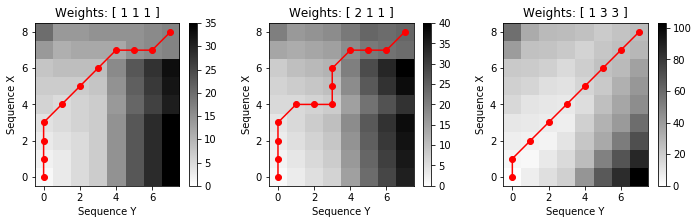

In [3]:
X = [1, 1, 1, 1, 2, 1, 1, 6, 6]
Y = [0, 3, 3, 3, 9, 9, 7, 7]

print(r'Accumulated cost matrix and optimal warping path for different local weights:')
plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 3, 1)
weights_mul = np.array([1, 1, 1])
title='Weights: '+'[ '+''.join(str(s)+' ' for s in weights_mul)+']'
compute_plot_D_P(X, Y, ax=ax, weights_mul=weights_mul, title=title)

ax = plt.subplot(1, 3, 2)
weights_mul = np.array([2, 1, 1])
title='Weights: '+'[ '+''.join(str(s)+' ' for s in weights_mul)+']'
compute_plot_D_P(X, Y, ax=ax, weights_mul=weights_mul, title=title)

ax = plt.subplot(1, 3, 3)
weights_mul = np.array([1, 3, 3])
title='Weights: '+'[ '+''.join(str(s)+' ' for s in weights_mul)+']'                                                      
compute_plot_D_P(X, Y, ax=ax, weights_mul=weights_mul, title=title)

plt.tight_layout()

## Global Constraints

One common DTW variant is to impose **global constraints** on the admissible warping paths. Such constraints not only speed up DTW computations but also prevent "pathological" alignments
by globally controlling the overall course of a warping path. More precisely, let $R\subseteq [1:N]\times[1:M]$ be a subset referred to as a global **constraint region**. Then a **warping path relative to $R$** is a warping path that entirely runs within the region $R$. The **optimal warping path relative to $R$**, denoted by $P^\ast_{R}$, is the cost-minimizing warping path among all warping paths relative to $R$. The following figure shows two global constraint regions known as the **Sakoe&ndash;Chiba band** and the **Itakura parallelogram**. Alignments of cells can be selected only from the respective shaded region.

<img src="../data/C3/FMP_C3_F18_text.png" width="500px" align="center" alt="C1">

For a general constraint region $R$, the path $P^\ast_{R}$ can be computed similarly to the unconstrained case by formally setting $\mathbf{C}(n,m):=\infty$ for all $(n,m)\in [1:N]\times[1:M]\setminus R$. Therefore, in the computation of $P^\ast_{R}$ only the cells that lie in $R$ need to be evaluated. This may significantly speed up the DTW computation. However, the usage of global constraint regions is also problematic, since the unconstrained optimal warping path $P^\ast$ may traverse cells outside the specified constraint region. In this case, the constrained optimal warping path $P^\ast_{R}$  does not coincide with $P^\ast$ (see the last case of the above figure). In the following code cell, we call the function `librosa.sequence.dtw` with different constraint regions determined by a a Sakoe-Chiba band. 

<!--**Note**: In the following example, the warping path does not begin at $(1, 1)$. The reason for this is a bug in the backtracking procedure in `librosa`. This was [fixed](https://github.com/librosa/librosa/pull/920) and will be solved in the next version of `librosa`. However, currently the fix is not included the the latest version.-->

Accumulated cost matrix and optimal warping path for different constraint regions:


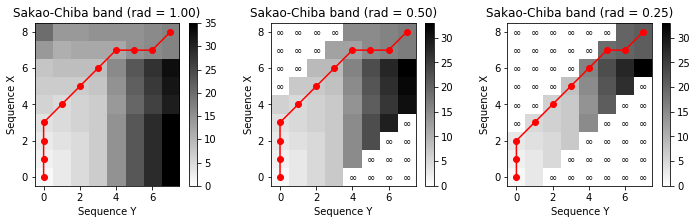

In [4]:
X = [1, 1, 1, 1, 2, 1, 1, 6, 6]
Y = [0, 3, 3, 3, 9, 9, 7, 7]

print(r'Accumulated cost matrix and optimal warping path for different constraint regions:')
plt.figure(figsize=(10, 3))
global_constraints = True

ax = plt.subplot(1, 3, 1)
band_rad = 1
title='Sakao-Chiba band (rad = %.2f)'%band_rad
compute_plot_D_P(X, Y, ax=ax, global_constraints=global_constraints, band_rad=band_rad,title=title)

ax = plt.subplot(1, 3, 2)
band_rad = 0.5
title='Sakao-Chiba band (rad = %.2f)'%band_rad
compute_plot_D_P(X, Y, ax=ax, global_constraints=global_constraints, band_rad=band_rad,title=title)

ax = plt.subplot(1, 3, 3)
band_rad = 0.25
title='Sakao-Chiba band (rad = %.2f)'%band_rad
compute_plot_D_P(X, Y, ax=ax, global_constraints=global_constraints, band_rad=band_rad,title=title)

plt.tight_layout()

## Multiscale DTW

When using the concept of global constraint regions, one needs to make sure that the optimal warping path to be computed actually lies  within this region. Since this path is not known 
a priori, it is often difficult to find a good trade-off between choosing the constraint region as small as possible (to speed up computations) but large enough to contain the desired path. One possible strategy to increase the probability of finding the "right" path is to use data-dependent constraint regions instead of a data-independent, fixed constraint region. This idea can be realized by a [**multiscale approach**](https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2006_MuellerMattesKurth_MultiscaleAudioSynchronization_ISMIR.pdf) to DTW, where the general strategy is to recursively project an optimal warping path computed at a coarse resolution level to the next higher level and then to refine the projected path. The following figure summarizes the main steps of such an approach: An optimal warping computed on a coarse resolution level is projected onto a finer resolution level. Along with a small neighborhood (to increase robustness of the overall procedure), this defines a constraint region used to compute a warping path on the finer resolution level. For details, see Section 3.2.2.4 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015]</a>.

<img src="../data/C3/FMP_C3_F19.png" width="500px" align="center" alt="C1">

## Further Notes

* The article ["An Efficient Multiscale Approach to Audio Synchronization"](https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2006_MuellerMattesKurth_MultiscaleAudioSynchronization_ISMIR.pdf) shows how the multiscale approach can be applied for [music synchronization](../C3/C3_MusicSynchronization.ipynb).
* Extending this work, the article ["Memory-Restricted Multiscale Dynamic Time Warping"](https://www.audiolabs-erlangen.de/fau/professor/mueller/publications/2016_PraetzlichDriedgerMueller_MrMsDTW_ICASSP.pdf) introduces a DTW approach that works with a pre-defined memory quota.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div> 

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>